In [2]:
# Section-1

%matplotlib inline

import warnings
import re
import json
import pandas as pd
import matplotlib
import gensim
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')
from pprint import pprint
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from gensim.utils import simple_preprocess
from nltk.stem.porter import *
from gensim import corpora, models
from nltk import tokenize
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize   
from collections import defaultdict, Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
s = SentimentIntensityAnalyzer()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

[nltk_data] Downloading package wordnet to C:\Users\Vuthej
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Vuthej
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Section-2
# To load the '521_amazon.json' data which has amazon reviews for the selected 11 mobile phones.

with open('521_amazon.json') as f:
    amz_data = json.load(f)
    
pprint(amz_data['Google Pixel 3 XL'])

{'based_on': '840',
 'rating': '4.6',
 'reviews,useful,rating,date': [['Guys it is an honestly the phone is just '
                                 'okay.I bought this 3 months ago I guess, '
                                 "it's working fine.You know if you are buying "
                                 'a stuff above 70k, you expect it should have '
                                 'some flaunting features. It has none. '
                                 'Seriously none.If you are interested in '
                                 'photography then only go for it, else NO.I '
                                 'was a little sceptical too, but then I '
                                 "bought it, and it's just okayThere's no "
                                 'awesome thing about it. Even camera in night '
                                 'mode gets real average.I have been facing '
                                 'issue with screen display. I tried to fix it '
                          

In [4]:
# Section-3
# To load the '521_amazon.json' data which has amazon reviews for the selected 11 mobile phones.

with open('521_flipkart.json') as p:
    flp_data = json.load(p)
    
pprint(flp_data['Google Pixel 3 XL'])

{'based_on': '868',
 'rating': '4.6',
 'reviews,useful,rating,date': [['there are a few glitches here and there with '
                                 'the software, but hopefully it will get '
                                 'fixed with a software update\n'
                                 'camera is best in class\n'
                                 'battery is average\n'
                                 'pure android experience is awesome\n'
                                 'cannot connect directly to a computer since '
                                 "there's no USB cable support (both sides of "
                                 'the cable provided is a type c)\n'
                                 'needs better memory management for keeping '
                                 'more apps open in memory\n'
                                 'feels like internal memory is too low(mine '
                                 'already 70% used)',
                                 '38 users foun

In [5]:
# Section-4
# This code helps in making below modifications to the input data
# 'reviews' -- To convert all cases to lower and to strip spaces towards the ends.
# 'useful' -- To convert string data to integer i.e. '7 users found this review helpful' to '7'
# 'rating' -- To convert string data to integer i.e.  '1 stars' to '1'
# 'date' -- To convert string data to datetime object i.e. '02 Jan 2019,' to datetime.date(2019, 1, 2)

ana_df = {}

print("Before modifying : ", amz_data['Google Pixel 3 XL']['reviews,useful,rating,date'][4])

for i in amz_data:
    ana_df[i] = []
    for j in amz_data[i]['reviews,useful,rating,date']:
        tmp = []
        tmp.append(j[0].lower().strip())
        tmp.append(int(j[1].split()[0]))
        tmp.append(int(j[2].split()[0]))
        tmp.append(datetime.strptime(j[3], '%d %b %Y,').date())
        ana_df[i].append(tmp)
        
for i in flp_data:
    for j in flp_data[i]['reviews,useful,rating,date']:
        tmp = []
        tmp.append(j[0].lower().strip())
        tmp.append(int(j[1].split()[0]))
        tmp.append(int(j[2].split()[0]))
        tmp.append(datetime.strptime(j[3], '%d %b %Y,').date())
        ana_df[i].append(tmp)
        
print("\nAfter modifying : ", ana_df['Google Pixel 3 XL'][4])

Before modifying :  ['Worst product of Google. Mobile is like iron box. U can put omblete. Make dosa. Etc. Over heating issue.           ', '7 users found this review helpful', '1 stars', '02 Jan 2019,']

After modifying :  ['worst product of google. mobile is like iron box. u can put omblete. make dosa. etc. over heating issue.', 7, 1, datetime.date(2019, 1, 2)]


In [6]:
# Section - 5
# This helps in converting short notations in the English language to an elaborated one.

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [7]:
# Section-6
# This code helps in identifying the stopwords which can be further used while converting word to vector.
# However, there will be certain stopwords in the reviews which we need to retain in order to correctly assess the sentiment.
# Hence we have created a list of words to pull out from the stopwords.

stops = set(stopwords.words("english"))
stops_rm = set(['above','against','ain','any','aren','because','below','didn','couldn','doesn','does','down','few','hadn','isn',"isn't",'mightn','more','most','mustn','no','nor','not','now','off','out','over','too','under','until','up','ve','very'])
stops = stops.difference(stops_rm)


In [8]:
# Section-7
# Function 'Lemmatize_stemming' helps in identifying the root form of all the words in the reviews.
# Function 'preprocess' helps removing the identified stop words from the reviews. It also filter out the words with length less than 2.

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos = 'v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stops and len(token) >= 2:
            result.append(lemmatize_stemming(token))
    return result

In [9]:
# Section-8
# This code utilizes the contractions list along with the above specified functions to lemmatizze and perform pre-processing.
# In addition to pre-process function, we are filtering out below aspects..
#    -> All the special characters
#    -> All the single characters
#    -> Replace multiple spaces with single space

## Note : Though Sentiment Vader provides sentiment for emojis and slang words, we felt they might dilute the overall sentiment if in case
## the reivew seems to be sarcastic. Based on this assumption, we have removed emojis but retained slang words.


for j in ana_df:
    for ind,i in enumerate(ana_df[j]):
        k = i[0].split()
        tmp = []
        for word in k:
            if word in contractions:
                tmp.append(contractions[word])
            else:
                tmp.append(word)
        i[0] = " ".join(tmp)
        # Remove all the special characters
        i[0] = re.sub(r'[^a-zA-Z0-9.]+', ' ', str(i[0]))
        # remove all single characters
        i[0]= re.sub(r'\s+[a-zA-Z]\s+', ' ', i[0])
        # Remove single characters from the start
        i[0] = re.sub(r'\^[a-zA-Z]\s+', ' ', i[0]) 
        # Substituting multiple spaces with single space
        i[0] = re.sub(r'\s+', ' ', i[0], flags=re.I)
        # Removing prefixed 'b'
        i[0] = re.sub(r'^b\s+', '', i[0])
        ana_df[j][ind] = i


In [10]:
# Section-9
# This code creates a dataframe with modified values from ['review', 'useful', 'rating', 'date']. Additionnally adds a column for index.
# 'Processed_review' column further maps all the rootwords from the reviews.
# Addition of the sentiment ('positive', 'negative', 'neutral' and 'compound') obtained from sentiment vader.

ana_dfs = {}
for i in ana_df:
    ana_dfs[i] = pd.DataFrame(ana_df[i], columns = ['review', 'useful', 'rating', 'date'])
    ana_dfs[i]['index'] = ana_dfs[i].index
    ana_dfs[i]['processed_review'] = ana_dfs[i]['review'].map(preprocess)
    ana_dfs[i]['processed_review'] = ana_dfs[i]['processed_review'].apply(lambda x: ' '.join(x))
    ana_dfs[i]["sentimentscores"] = ana_dfs[i]["review"].apply(lambda x : s.polarity_scores(x))
    ana_dfs[i] = pd.concat([ana_dfs[i].drop(['sentimentscores'], axis = 1), ana_dfs[i]['sentimentscores'].apply(pd.Series)], axis = 1)
    ana_dfs[i] = ana_dfs[i].loc[:,~ana_dfs[i].columns.duplicated()]
ana_dfs["Lenovo Z2 Plus 64GB"]

,review,useful,rating,date,index,processed_review,neg,neu,pos,compound
0,no problem at all.,0,4,2018-03-20,0,no problem,0.710,0.290,0.000,-0.5994
1,mob is automatically operating all the functio...,0,1,2018-03-19,1,mob automat oper function automat hotspot begi...,0.156,0.844,0.000,-0.5423
2,too good phone and has great battery backup an...,0,5,2018-03-19,2,too good phone great batteri backup use month ...,0.000,0.620,0.380,0.9098
3,i am not satisfied with u,0,1,2018-03-18,3,not satisfi,0.437,0.563,0.000,-0.3252
4,screen freezes all time after updating to andr...,0,3,2018-03-18,4,screen freez time updat android,0.136,0.864,0.000,-0.0258
...,...,...,...,...,...,...,...,...,...,...
6257,nice phone. good fingerprint every thing done ...,0,5,2018-01-15,6257,nice phone good fingerprint everi thing do hel...,0.000,0.607,0.393,0.8126
6258,excellent phone at this price. battery life is...,0,4,2018-01-13,6258,excel phone price batteri life excel camera ve...,0.000,0.531,0.469,0.9689
6259,poor battery capacity and produce heavy heat,0,1,2018-01-13,6259,poor batteri capac produc heavi heat,0.341,0.659,0.000,-0.4767
6260,this phone is best other mobile,0,5,2018-01-12,6260,phone best mobil,0.000,0.543,0.457,0.6369


In [11]:
# Section-10
# In order to have the plots correctly display the reviews in chronological order, we have sorted them based on the entry date of reviews.

plot_dfs = ana_dfs
for i in plot_dfs:
    plot_dfs[i] = plot_dfs[i].sort_values('date')
plot_dfs["Google Pixel 3 XL"]

,review,useful,rating,date,index,processed_review,neg,neu,pos,compound
30,so this was delivered yesterday. here what thi...,8,5,2018-11-02,30,deliv yesterday think build qualiti kinda down...,0.038,0.892,0.070,0.9115
27,delighted to get my hands on the brand new pix...,20,5,2018-11-02,27,delight get hand brand new pixel xl bang promi...,0.000,0.707,0.293,0.9100
26,this phone feels really fast everything feels ...,29,5,2018-11-02,26,phone feel realli fast everyth feel butteri sm...,0.017,0.814,0.168,0.9368
80,the display is sharper and responsive to touch...,0,5,2018-11-03,80,display sharper respons touch camera fantast c...,0.000,0.836,0.164,0.7269
45,got it delivered in just one day .. amazing,1,4,2018-11-03,45,get deliv one day amaz,0.000,0.678,0.322,0.5859
...,...,...,...,...,...,...,...,...,...,...
2,great phone with good number of android featur...,9,5,2019-05-19,2,great phone good number android featur excel t...,0.071,0.545,0.385,0.8689
6,this smartphone is out of this world. design o...,6,4,2019-05-21,6,smartphon out world design predecessor camera ...,0.000,0.885,0.115,0.5267
0,guys it is an honestly the phone is just okay....,14,3,2019-05-21,0,guy honest phone okay buy month ago guess work...,0.030,0.847,0.123,0.9208
5,one of the best camera phone in the town.....,6,5,2019-06-06,5,one best camera phone town,0.000,0.656,0.344,0.6369


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


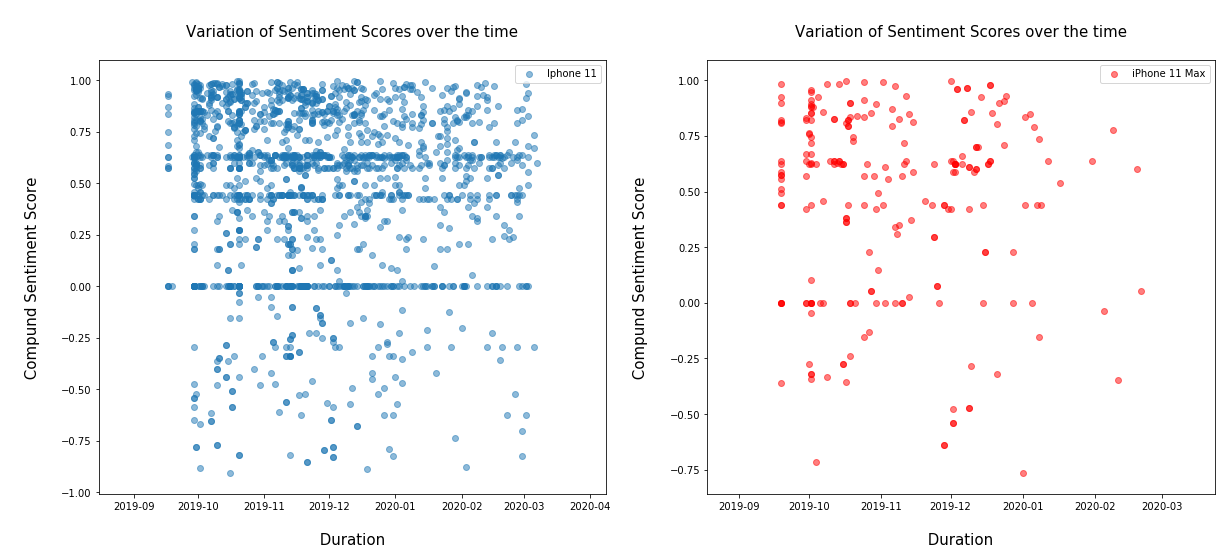

In [12]:
# Section-11
# Code to display the scatter plots for 'iPhone 11' and 'iPhone 11 Max' for date vs sentiment.

f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.scatter(plot_dfs["Apple iPhone 11"]['date'], plot_dfs["Apple iPhone 11"]['compound'], alpha = 0.5, label = "Iphone 11")
ax.set_title('Variation of Sentiment Scores over the time\n', fontsize = 15)
ax.set_xlabel("\n Duration ", fontsize = 15)
ax.set_ylabel("\n Compund Sentiment Score \n", fontsize = 15)
ax.legend()
ax2.scatter(plot_dfs["Apple iPhone 11 Pro Max"]['date'], plot_dfs["Apple iPhone 11 Pro Max"]['compound'], alpha = 0.5, 
            color = 'red', label = "iPhone 11 Max")
ax2.set_title('\nVariation of Sentiment Scores over the time\n', fontsize = 15)
ax2.set_xlabel("\n Duration ", fontsize = 15)
ax2.set_ylabel("\n Compund Sentiment Score \n", fontsize = 15)
_=ax2.legend()
warnings.filterwarnings('ignore')

## Observations from above plots

Above scatter plot shows the differentiation between positive, negative and neutral reviews.
However, in order to observe the variation keenly for every feature, we created a list depicting features/parameters of mobile phones.
Number of reviews and the ratio of polarities were maintained almost similar through out the period for 'iPhone 11'.
But this wasn't the case with 'iPhone 11 Max' as the reviews gradually decreased after December 2019.


parameters=[['design'],['display','screen'],['performance','ram','processor'],['storage','memory'],['camera','cam','pixels','mp','video'],['battery','charging'],['network','connectivity'],['loudspeaker','sound','speaker','audio','multimedia'],['fingerprint','sensor']]

This will help us in identifying the sentiment polarities more accurately based on features.

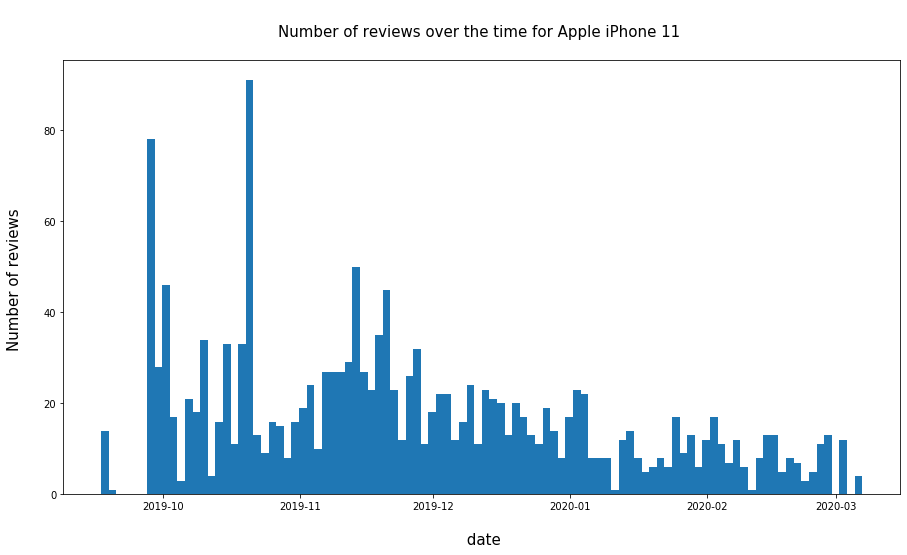

In [13]:
# Section-12
# Code to display the variation in reviews received during the given duration for a sample phone. 'Apple iPhone 11'.

plt.figure(figsize=(15,8))
plt.hist(plot_dfs["Apple iPhone 11"]['date'], bins = 100)
plt.xlabel("\n date", fontsize = 15)
plt.ylabel("Number of reviews \n", fontsize = 15)
_ = plt.title("\nNumber of reviews over the time for Apple iPhone 11 \n", fontsize = 15)

## Observations for 'iPhone 11'

Reviews peaked towards the beginning but we can still see zero reviews at the beginning. Reason being that the users might have taken couple of days to examine the features before reporting their reviews.

We can also observe the outliers in the month of October but not towards the end (i.e. March 2020).
It can be due to couple of reasons. One, because of not releasing any updates/modifications by the company. Two, the peak is expected during the initial days of the release rather than receiving at a later stage.

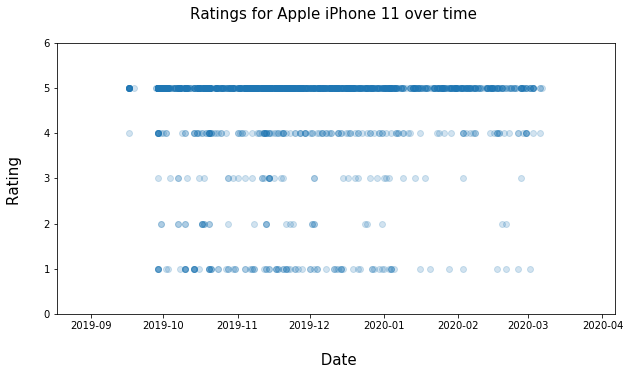

In [14]:
# Section-13
# Code to display the variation in ratings received during the given duration for a sample phone. 'Apple iPhone 11'.

plt.figure(figsize = (10,5))
plt.scatter(plot_dfs["Apple iPhone 11"]['date'],plot_dfs["Apple iPhone 11"]['rating'], alpha = 0.2)
plt.ylim(0,6,1)
plt.xlabel("\n Date", fontsize = 15)
plt.ylabel("Rating \n", fontsize = 15)
_ = plt.title("Ratings for Apple iPhone 11 over time \n", fontsize = 15)

## Observations

This product received more dense ratings of '5' and '4' than rest of the ratings. Hence it can be considered to be a good product.

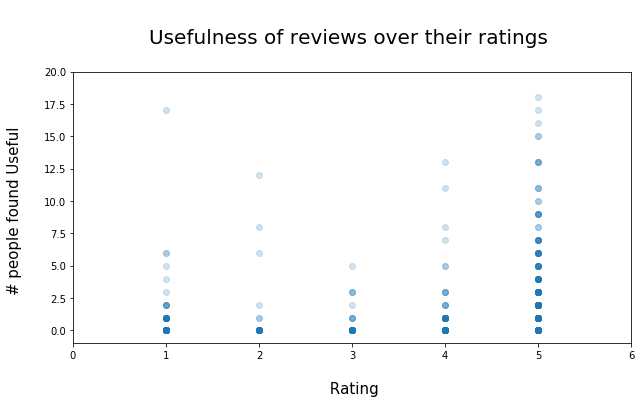

In [15]:
# Section-14
# Code to display the count of people that actually found a review as useful during the given duration for a sample phone. 'Apple iPhone 11'.

plt.figure(figsize = (10,5))
plt.scatter(plot_dfs["Apple iPhone 11"]['rating'], plot_dfs["Apple iPhone 11"]['useful'], alpha = 0.2)
plt.ylim(-1,20)
plt.xlim(0,6,1)
plt.xlabel("\n Rating",fontsize = 15)
plt.ylabel("# people found Useful \n", fontsize = 15)
_ = plt.title("\nUsefulness of reviews over their ratings \n", fontsize = 20)

## Observations

As expected, we can observe more people finding the reviews with rating 5 as useful.

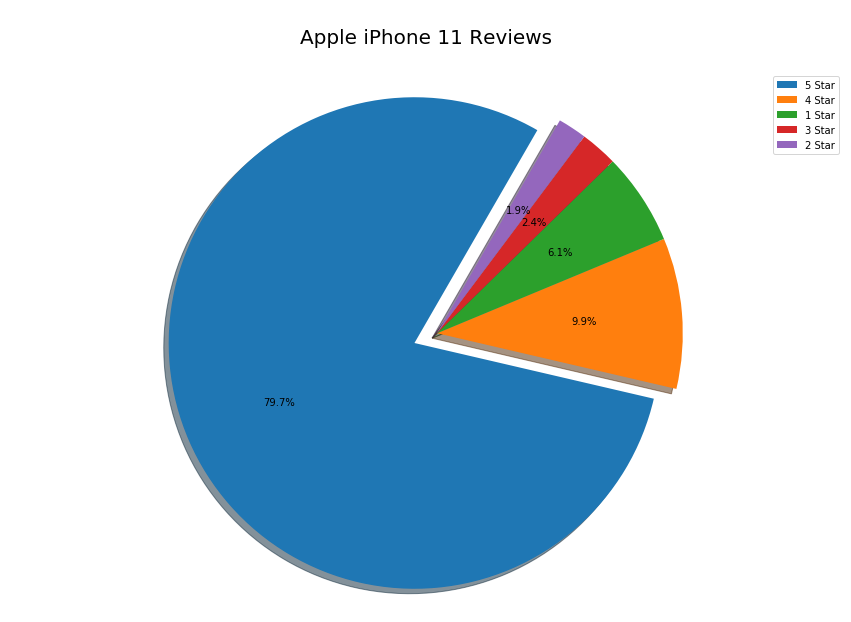

In [16]:
# Section-15
# Code to display the distribution of review ratings for a sample phone. 'Apple iPhone 11'

sizes = []
labels = []
for key, value in dict(plot_dfs['Apple iPhone 11']['rating'].value_counts()).items():
    labels.append(str(key) + " Star")
    sizes.append(value)
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots(figsize = (15,10))
patches, texts, per = plt.pie(sizes, explode=explode, shadow=True, startangle=60, autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
ax1.axis('equal')
plt.title("\nApple iPhone 11 Reviews\n", fontsize = 20)
plt.tick_params(labelsize=15)
plt.show()


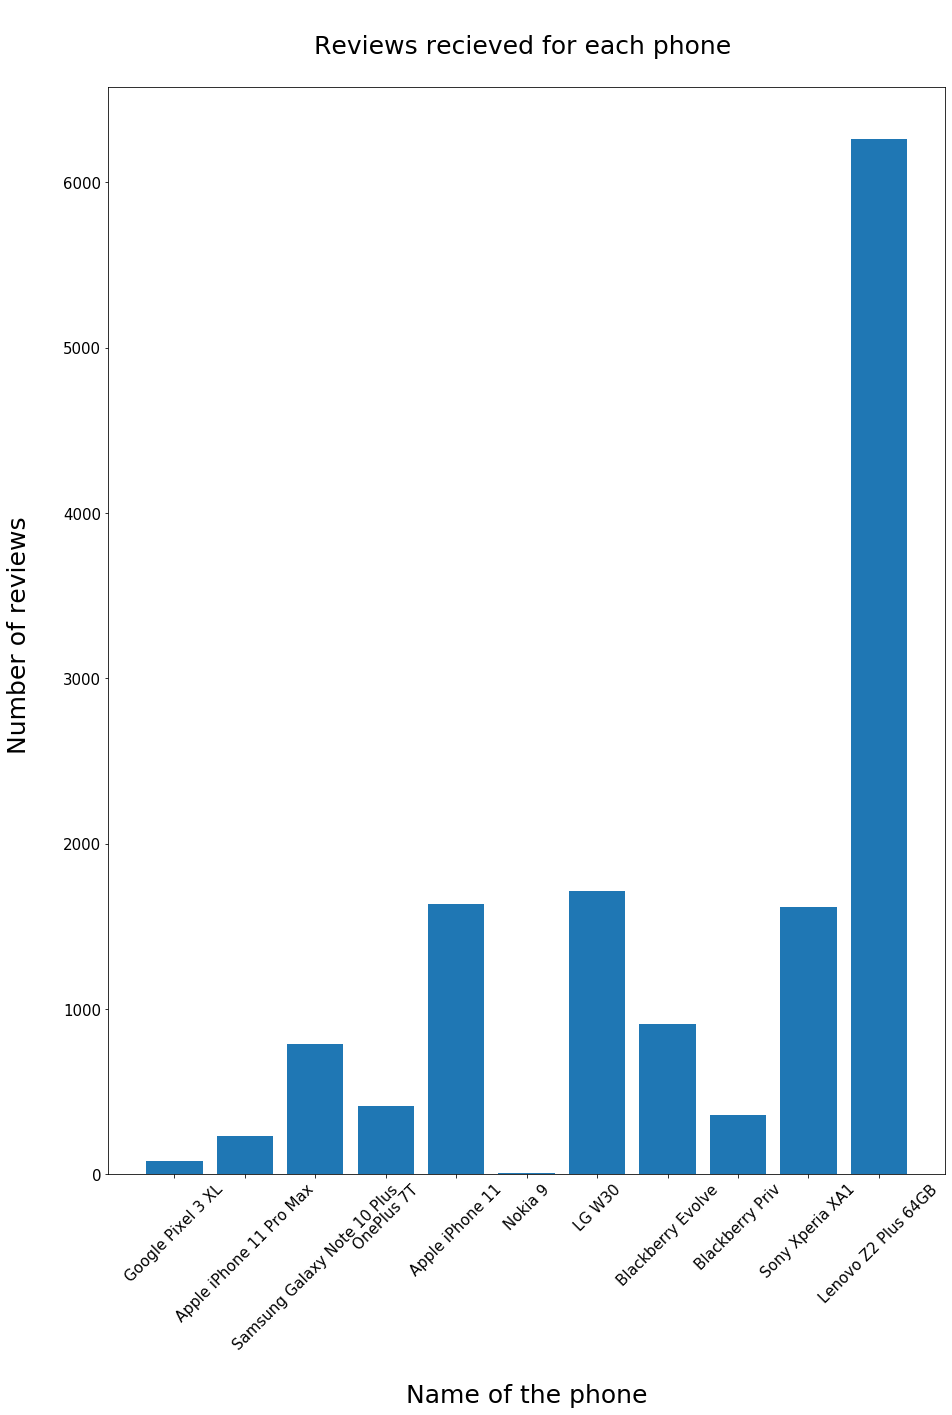

In [17]:
# Section-16
# In order for us to better understand the count of reviews received per phone we have plotted below barplot.

total_reviews = {}

for phone in ana_dfs:
    total_reviews[phone] = ana_dfs[phone]['review'].shape[0]

plt.figure(figsize = (15,20))
test = [total_reviews[phone_name] for phone_name in total_reviews]
x = []
y = []
for phone in total_reviews.keys():
    x.append(phone)
    y.append(total_reviews[phone])
plt.bar(x, y)
plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("\n Name of the phone ", fontsize = 25)
plt.ylabel("Number of reviews \n", fontsize = 25)
_ = plt.title("\nReviews recieved for each phone \n",fontsize = 25)


## Observations

'Nokia 9' received just 8 reviews whereas 'Lenovo Z2 Plus 64GB' received more than 6000 reviews.

Our Application specifically helps situations like these of 'Lenovo Z2 Plus 64GB' where user needs to invest more time to read reviews.

But because of very high and very low reviews recieived for 'Lenovo Z2 Plus 64GB' and 'Nokia 9' respectively, we had to apply logarithm before plotting the barplot to produce decent display.

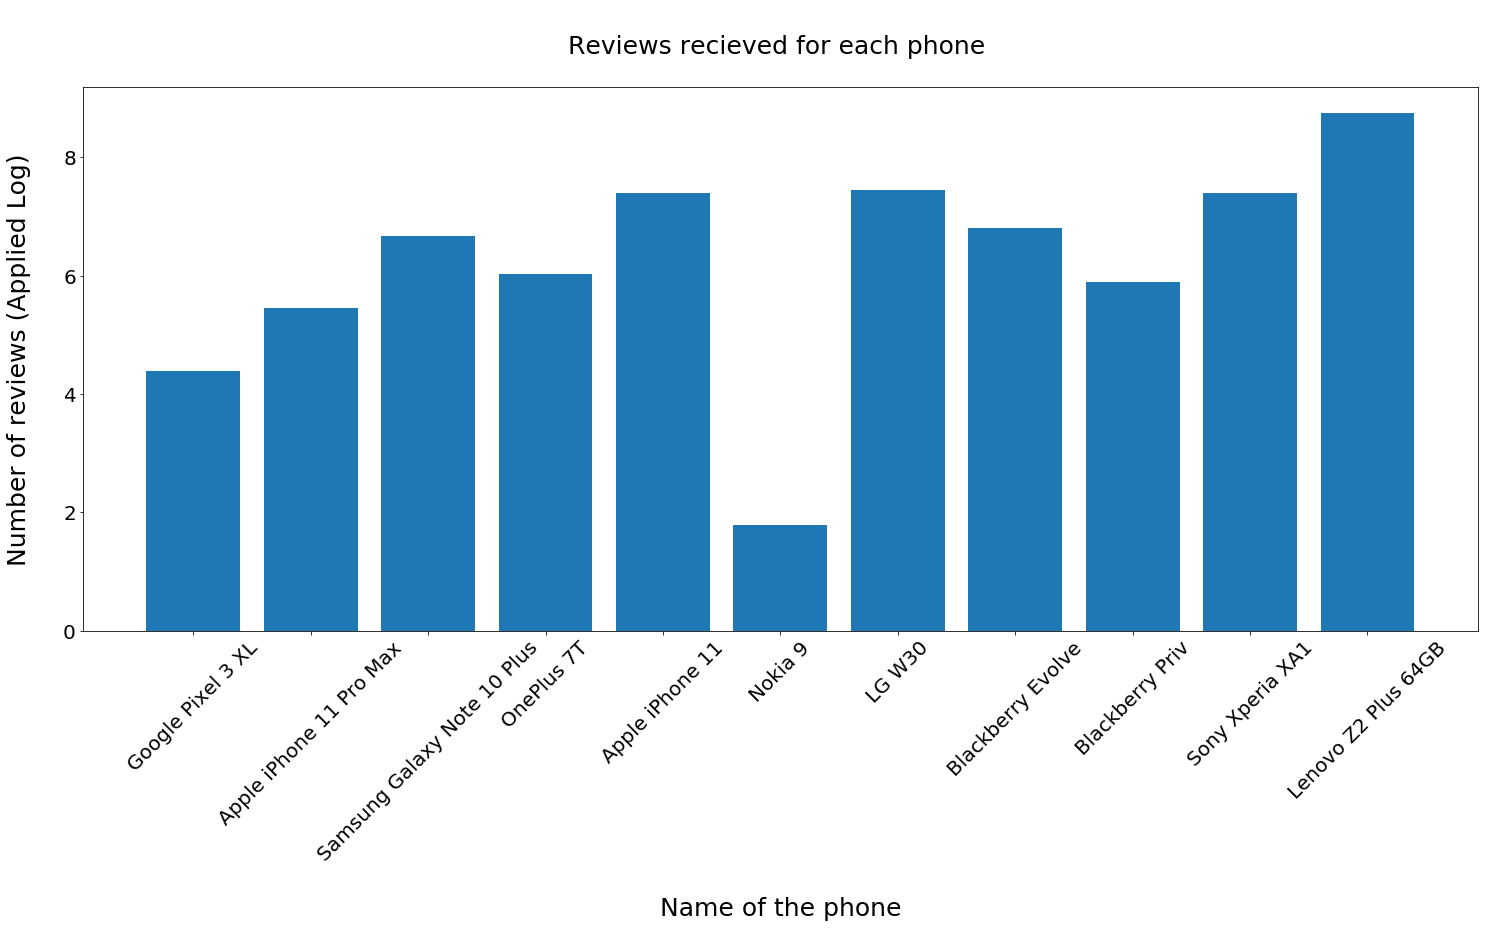

In [18]:
# Section-17
# Bar plot by applying logarithm to the number of reviews i.e. y-axis

total_reviews = {}

for phone in ana_dfs:
    total_reviews[phone] = ana_dfs[phone]['review'].shape[0]

plt.figure(figsize = (25,10))
test = [total_reviews[phone_name] for phone_name in total_reviews]
x = []
y = []
for phone in total_reviews.keys():
    x.append(phone)
    y.append(total_reviews[phone])
plt.bar(x, np.log(y))
plt.xticks(rotation = 45, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("\n Name of the phone ", fontsize = 25)
plt.ylabel("Number of reviews (Applied Log)\n", fontsize = 25)
_ = plt.title("\nReviews recieved for each phone \n",fontsize = 25)

In [28]:
# Section-18
# From this section onwards, our main focus will be on the review text to generate the sentiment on Topics which will be created by LDA.

new_list = {}
for i in amz_data:
    new_list[i] = []
    for j in amz_data[i]['reviews,useful,rating,date']:
        new_list[i].append(j[0].lower().strip())
for i in flp_data:
    for j in flp_data[i]['reviews,useful,rating,date']:
        new_list[i].append(j[0].lower().strip())

new_list['Lenovo Z2 Plus 64GB'][0]


'no problem at all.'

In [29]:
# Section-19
# Code to save the cleaned reviews of each phone into a dictionary

clean_new_list = {}

for j in new_list:
    
    clean_new_list[j] = []
    for i in new_list[j]:
        
        i = i.split()
        tmp = []
        for word in i:
            if word in contractions:
                tmp.append(contractions[word])
            else:
                tmp.append(word)
        text = " ".join(tmp)
        # Remove all the special characters
        text = re.sub(r'[^a-zA-Z0-9.]+', ' ', text)
        # remove all single characters
        text= re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        # Remove single characters from the start
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
        # Substituting multiple spaces with single space
        text= re.sub(r'\s+', ' ', text, flags=re.I)
        # Removing prefixed 'b'
        text = re.sub(r'^b\s+', '', text)
        
        
        clean_new_list[j].append(text)

print(len(clean_new_list['Google Pixel 3 XL']))

clean_new_list['Google Pixel 3 XL'][0]

81


'guys it is an honestly the phone is just okay.i bought this 3 months ago guess it is working fine.you know if you are buying stuff above 70k you expect it should have some flaunting features. it has none. seriously none.if you are interested in photography then only go for it else no.i was little sceptical too but then bought it and it is just okaythere no awesome thing about it. even camera in night mode gets real average.i have been facing issue with screen display. tried to fix it using some feedbacks but it just did not work out.i have not tried hardcore gaming.most importantly phone will go unnoticed everywhere cause of it is typical design unlike an iphone.invest in iphone if you are really ready for 70k.'

In [30]:
# Section-20
# We've identified common features and then divided the reviews based on features for every phone.

parameters=[['design'],['display','screen'],['performance','ram','processor'],['storage','memory'],['camera','cam','pixels','mp','video'],['battery','charging'],['network','connectivity'],['loudspeaker','sound','speaker','audio','multimedia'],['fingerprint','sensor']]

In [31]:
# Section-21
# This function initially splits the words in reviews and compares itself with the words in paramaetes/features listed above.
# Seggregation of reviews is then done based on the features.

# In order to avoid the mixing of features which might be the case when we take an entire review, as a reviewer might discuss about 
# various features in a single review. So by separating the review into sentences, we can capture insights for each feature more precisely.

def par_split(data):
    splitted = defaultdict(set)
    for i in data:
        sents = tokenize.sent_tokenize(i)
        for sent in sents:
            s = sent.split()
            tmp = False
            for word in s:
                for p in parameters:
                    if word in p:
                        splitted[p[0]].add((sent,i))
                        tmp=True
            if tmp == False:
                splitted['others'].add((sent,i))
    return splitted
        
        
splitted_dict = {}
for i in clean_new_list:
    splitted_dict[i] = []
    splitted_dict[i] = par_split(clean_new_list[i])

splitted_dict['Google Pixel 3 XL']["camera"]

{(' best android smart phone have been using pixel 2xl and now upgraded to pixel3xl... biggest difference is screen resolution ... if you want to own best android smart phone this is the one ..nothing comes close to performance and camera of pixel3xl... use it to believe it .',
  ' best android smart phone have been using pixel 2xl and now upgraded to pixel3xl... biggest difference is screen resolution ... if you want to own best android smart phone this is the one ..nothing comes close to performance and camera of pixel3xl... use it to believe it .'),
 ('as per absurd reply from pixel 3xl customer care service video call is not possible in pixel phone without google duo.',
  'camera is awesome. display is also fantastic. one point that irks me is pixel 3 xl do not have the volte feature. it is customer care support is misguiding its customers by suggesting them to take the help of mobile carrier services. jio sim offers this feature whereby we do not keep our mobile data on to execute

In [32]:
# Section-22
# To create individual dataframes for every listed feature in every phone.

dfs = {}
for i in splitted_dict:
    dfs[i] = {}
    for j in splitted_dict[i]:
        dfs[i][j] = pd.DataFrame(list(map(lambda x: x[0], splitted_dict[i][j])))
        dfs[i][j]['index'] = dfs[i][j].index

dfs['Google Pixel 3 XL']['camera']


,0,index
0,excellent camera phone.,0
1,even camera in night mode gets real average.i ...,1
2,awesome product camera is extremely nice memor...,2
3,awesome camera probably best with first hand g...,3
4,its nice phone but the price is way 2 much the...,4
5,best camera but battery backup not good for su...,5
6,design of is predecessors and camera is simply...,6
7,proshigh resolution display with really crisp ...,7
8,the front camera can take super wide angle sel...,8
9,awesome phone for 2018 best camera ever in sma...,9


In [33]:
# Section-23
# For the vectorizer to function, we are providing the root words in verb form from 'preprocess' function which is defined at the beginning.

processed_docs = {}

for i in dfs:
    processed_docs[i] = {}
    for j in dfs[i]:
        processed_docs[i][j] = dfs[i][j][0].map(preprocess)

processed_docs['Google Pixel 3 XL']['camera'][0]


['excel', 'camera', 'phone']

In [34]:
# Section-24
# For efficiency purpose, rather than passing the entire data to build the corpus, we have individually built the dictionaries for
# each feature in every phone.

dicti = {}
for i in processed_docs:
    dicti[i] = {}
    for j in processed_docs[i]:
        dicti[i][j] = gensim.corpora.Dictionary(processed_docs[i][j])

for i,j in dicti['Google Pixel 3 XL']['camera'].iteritems():
    print(i,j)

0 camera
1 excel
2 phone
3 averag
4 display
5 even
6 face
7 get
8 issu
9 mode
10 night
11 real
12 screen
13 awesom
14 extrem
15 love
16 manag
17 memori
18 much
19 nice
20 notch
21 product
22 too
23 top
24 best
25 first
26 googl
27 hand
28 probabl
29 softwar
30 amaz
31 price
32 way
33 backup
34 batteri
35 expens
36 good
37 man
38 not
39 overal
40 royal
41 design
42 predecessor
43 simpli
44 accident
45 add
46 advanc
47 also
48 android
49 ani
50 around
51 back
52 becaus
53 big
54 break
55 brighter
56 chin
57 compar
58 consbodi
59 crisp
60 date
61 easilysometim
62 edgescamera
63 featur
64 flicker
65 fluoresc
66 follow
67 front
68 glass
69 gorilla
70 great
71 help
72 incred
73 irrit
74 larg
75 later
76 light
77 lightn
78 like
79 limit
80 littl
81 look
82 lower
83 mobil
84 more
85 natur
86 oneplus
87 pie
88 proshigh
89 ram
90 react
91 realli
92 remov
93 resolut
94 review
95 saw
96 signific
97 singl
98 slide
99 slipperi
100 smoothsound
101 space
102 still
103 storageno
104 take
105 till
106 t

In [35]:
# Section-25
# Code to build corpus for each review based on dictionary that has been defined for that specific feature from above section.
# Bag of Words Model is being used by doc2bow.

bow_corpus = {}
for i in processed_docs:
    bow_corpus[i] = {}
    for j in processed_docs[i]:
        bow_corpus[i][j] = [dicti[i][j].doc2bow(doc) for doc in processed_docs[i][j]]


bow_corpus['Google Pixel 3 XL']['camera'][0]

[(0, 1), (1, 1), (2, 1)]

In [36]:
# Section-26
# TF-IDF Model is being applied on the above created bow_corpus.

corpus_tfidf = {}
for i in bow_corpus:
    corpus_tfidf[i] = {}
    for j in bow_corpus[i]:
        tfidf = models.TfidfModel(bow_corpus[i][j])
        corpus_tfidf[i][j] = tfidf[bow_corpus[i][j]]

from pprint import pprint
for doc in corpus_tfidf['Google Pixel 3 XL']['camera']:
    pprint(doc)
    break

[(0, 0.01761524410961315), (1, 0.9593060298882348), (2, 0.2818184596420754)]


In [37]:
# Section-27
# Applying Latent Dirichlet Allocation (LDA) model to the bag of words corpus (bow_corpus).
# We have now divided entire reviews from each feature to a cluster of 3. 
# For reviews falling in 'others' category, number of clusters will be 10.

lda_model = {}
for i in bow_corpus:
    lda_model[i] = {}
    for j in bow_corpus[i]:
        try:
            if j == 'others':
                lda_model[i][j] = gensim.models.LdaMulticore(bow_corpus[i][j], num_topics=10, id2word=dicti[i][j], passes = 2, workers = 2)
            else:
                lda_model[i][j] = gensim.models.LdaMulticore(bow_corpus[i][j], num_topics=3, id2word=dicti[i][j], passes = 2, workers = 2)
        except ValueError:
            continue
lda_model['Google Pixel 3 XL']['camera']


In [38]:
# Section-28
# Simple display of the topics that have been generated by LDA model as done above.

for idx, topic in lda_model['Apple iPhone 11']['camera'].print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.047*"iphon" + 0.040*"camera" + 0.016*"phone" + 0.014*"display" + 0.014*"appl" + 0.013*"use" + 0.012*"good" + 0.010*"wide" + 0.009*"not" + 0.009*"batteri"
Topic: 1 
Words: 0.059*"camera" + 0.029*"not" + 0.028*"good" + 0.027*"phone" + 0.018*"batteri" + 0.014*"awesom" + 0.013*"qualiti" + 0.010*"iphon" + 0.010*"best" + 0.009*"veri"
Topic: 2 
Words: 0.086*"camera" + 0.030*"batteri" + 0.025*"qualiti" + 0.022*"iphon" + 0.020*"perform" + 0.018*"good" + 0.017*"phone" + 0.015*"veri" + 0.015*"best" + 0.013*"great"


In [39]:
# Section-29
# Applying Latent Dirichlet Allocation (LDA) model to the TF-IDF corpus (corpus_tfidf).
# We have now divided entire reviews from each feature to a cluster of 3. 
# For reviews falling in 'others' category, number of clusters will be 10.

lda_model_tfidf = {}
for i in corpus_tfidf:
    lda_model_tfidf[i] = {}
    for j in corpus_tfidf[i]:
        try:
            if j == 'others':
                lda_model_tfidf[i][j] = gensim.models.LdaMulticore(corpus_tfidf[i][j], num_topics = 10, id2word = dicti[i][j], passes = 2, workers = 2)
            else:
                lda_model_tfidf[i][j] = gensim.models.LdaMulticore(corpus_tfidf[i][j], num_topics = 3, id2word = dicti[i][j], passes = 2, workers = 2)
        except ValueError:
            continue

for idx, topic in lda_model_tfidf['Google Pixel 3 XL']['camera'].print_topics(-1):
    print('\nTopic: {}\t \nWord: {}'.format(idx, topic))


Topic: 0	 
Word: 0.009*"world" + 0.008*"best" + 0.008*"town" + 0.008*"one" + 0.008*"design" + 0.008*"phone" + 0.007*"smooth" + 0.007*"hand" + 0.007*"not" + 0.007*"predecessor"

Topic: 1	 
Word: 0.013*"awesom" + 0.009*"excel" + 0.009*"phone" + 0.008*"angl" + 0.008*"wide" + 0.008*"selfi" + 0.007*"usual" + 0.007*"go" + 0.007*"front" + 0.007*"want"

Topic: 2	 
Word: 0.008*"not" + 0.008*"get" + 0.008*"night" + 0.008*"sight" + 0.007*"display" + 0.007*"awesom" + 0.007*"heat" + 0.007*"product" + 0.006*"mode" + 0.006*"memori"


In [40]:
# Section-30
# Similarity Measurement for each sentence towards the 3 clusters from LDA Bag_of_words model.

for index, score in sorted(lda_model['Google Pixel 3 XL']['camera'][bow_corpus['Google Pixel 3 XL']['camera'][0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model['Google Pixel 3 XL']['camera'].print_topic(index, 10)))


Score: 0.8201881051063538	 
Topic: 0.067*"camera" + 0.050*"phone" + 0.040*"best" + 0.023*"awesom" + 0.015*"pixel" + 0.013*"great" + 0.013*"good" + 0.013*"android" + 0.012*"use" + 0.012*"not"

Score: 0.09448400139808655	 
Topic: 0.038*"camera" + 0.012*"awesom" + 0.012*"front" + 0.010*"display" + 0.010*"mode" + 0.010*"get" + 0.010*"better" + 0.010*"memori" + 0.009*"oneplus" + 0.009*"night"

Score: 0.08532790094614029	 
Topic: 0.035*"not" + 0.028*"good" + 0.028*"oneplus" + 0.019*"camera" + 0.019*"app" + 0.014*"better" + 0.014*"pixel" + 0.013*"fast" + 0.013*"veri" + 0.012*"ani"


In [41]:
# Section-31
# Similarity Measurement for each sentence towards the 3 clusters from LDA TF-IDF model.

for index, score in sorted(lda_model_tfidf['Google Pixel 3 XL']['camera'][bow_corpus['Google Pixel 3 XL']['camera'][2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t topic No:{} \nTopic: {}".format(score, index,lda_model_tfidf['Google Pixel 3 XL']['camera'].print_topic(index)))


Score: 0.9512516260147095	 topic No:2 
Topic: 0.008*"not" + 0.008*"get" + 0.008*"night" + 0.008*"sight" + 0.007*"display" + 0.007*"awesom" + 0.007*"heat" + 0.007*"product" + 0.006*"mode" + 0.006*"memori"

Score: 0.025528404861688614	 topic No:1 
Topic: 0.013*"awesom" + 0.009*"excel" + 0.009*"phone" + 0.008*"angl" + 0.008*"wide" + 0.008*"selfi" + 0.007*"usual" + 0.007*"go" + 0.007*"front" + 0.007*"want"

Score: 0.023219959810376167	 topic No:0 
Topic: 0.009*"world" + 0.008*"best" + 0.008*"town" + 0.008*"one" + 0.008*"design" + 0.008*"phone" + 0.007*"smooth" + 0.007*"hand" + 0.007*"not" + 0.007*"predecessor"


In [42]:
# Section-32
# By using Sentiment Vader, we are generating polarities for each sentence.

for i in dfs:
    for j in dfs[i]:
        tmp_list=[]
        for k in bow_corpus[i][j]:
            tmp_list.append(sorted(lda_model_tfidf[i][j][k], key=lambda tup: -1*tup[1])[0][0])
        se = pd.Series(tmp_list)
        dfs[i][j]=dfs[i][j].rename(columns={0: "review"})
        dfs[i][j]['topic'] = se.values
        dfs[i][j]["sentimentscores"]=dfs[i][j]["review"].apply(lambda x : s.polarity_scores(x))
        dfs[i][j] = pd.concat([dfs[i][j].drop(['sentimentscores'], axis=1), dfs[i][j]['sentimentscores'].apply(pd.Series)], axis=1)
        dfs[i][j] = dfs[i][j].loc[:,~dfs[i][j].columns.duplicated()]


dfs['Google Pixel 3 XL']['camera']

,review,index,topic,neg,neu,pos,compound
0,excellent camera phone.,0,1,0.000,0.351,0.649,0.5719
1,even camera in night mode gets real average.i ...,1,2,0.000,1.000,0.000,0.0000
2,awesome product camera is extremely nice memor...,2,2,0.000,0.414,0.586,0.9516
3,awesome camera probably best with first hand g...,3,0,0.000,0.343,0.657,0.9100
4,its nice phone but the price is way 2 much the...,4,1,0.000,0.608,0.392,0.7964
5,best camera but battery backup not good for su...,5,2,0.133,0.598,0.269,0.4924
6,design of is predecessors and camera is simply...,6,0,0.000,0.661,0.339,0.6249
7,proshigh resolution display with really crisp ...,7,2,0.076,0.744,0.180,0.9612
8,the front camera can take super wide angle sel...,8,1,0.000,0.672,0.328,0.5994
9,awesome phone for 2018 best camera ever in sma...,9,1,0.037,0.588,0.375,0.9643


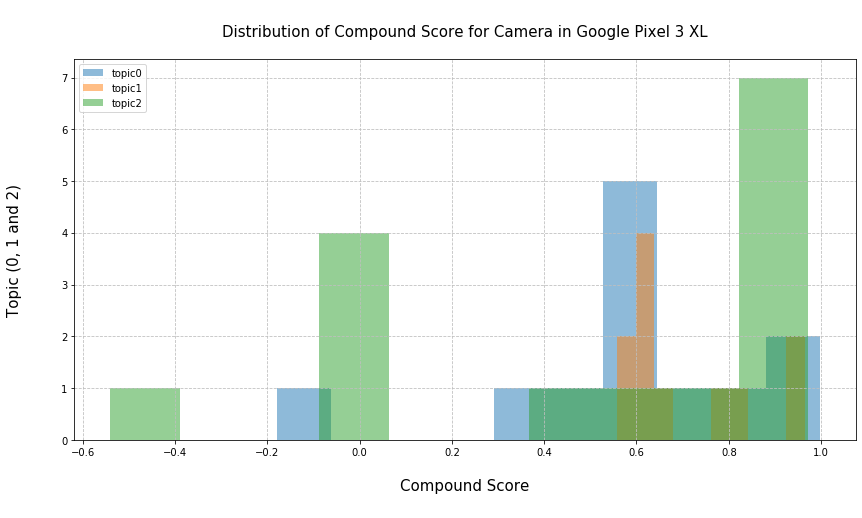

In [45]:
# Section-33
# Code to display the distribution of compound score for camera feature in sample phone (Google Pixel 3 XL) across 3 topics.


fig, ax = plt.subplots(1,1,figsize = (14,7))
plot=dfs["Google Pixel 3 XL"]['camera'].groupby('topic')['compound'].hist(alpha = 0.5, ax = ax, )
# plot=dfs["Apple iPhone 11"]['display'].groupby('topic')['compound'].hist(alpha = 0.5, ax = ax, )
ax.legend(['topic0', 'topic1', 'topic2'])
plt.xlabel("\nCompound Score\n", fontsize = 15)
plt.ylabel("Topic (0, 1 and 2)\n\n", fontsize = 15)
plt.title("\nDistribution of Compound Score for Camera in Google Pixel 3 XL\n", fontsize = 15)
# plt.title("\nDistribution of Compound Score for specific feature\n", fontsize = 15)
ax.grid(True, linestyle='--', color = '0.75')

## Observation

It can be concluded that Topic0 seems to have both more sentences displaying postive and negative sentiments.

In [46]:
# Section-34
# Assigning the aggregated polarities (positive, neutral, negative, negative_compound, positive_compound) for each feature in every phone to a dictionary.

topic_weights={}
for i in dfs:
    topic_weights[i]={}
    for j in dfs[i]:
        topic_weights[i][j]={}
        neg=dfs[i][j].groupby('topic')['neg']
        neu=dfs[i][j].groupby('topic')['neu']
        pos=dfs[i][j].groupby('topic')['pos']
        
        topic_weights[i][j]['neg']={}
        topic_weights[i][j]['neu']={}
        topic_weights[i][j]['pos']={}
        topic_weights[i][j]['comp_neg']={}
        topic_weights[i][j]['comp_pos']={}
        for x,y in neg:
            topic_weights[i][j]['neg'][x]=y.sum()
            
        for x,y in neu:
            topic_weights[i][j]['neu'][x]=y.sum()
            
        for x,y in pos:
            topic_weights[i][j]['pos'][x]=y.sum()

        comp_neg=dfs[i][j][dfs[i][j]['compound']<0].groupby('topic')['compound']
        comp_pos=dfs[i][j][dfs[i][j]['compound']>0].groupby('topic')['compound']
        
        for x,y in comp_neg:
            topic_weights[i][j]['comp_neg'][x]=y.sum()
            
        for x,y in comp_pos:
            topic_weights[i][j]['comp_pos'][x]=y.sum()


topic_weights["Google Pixel 3 XL"]['camera']

{'neg': {0: 0.197, 1: 0.037, 2: 0.414},
 'neu': {0: 8.088, 1: 6.589, 2: 10.781},
 'pos': {0: 3.715, 1: 4.3740000000000006, 2: 3.8050000000000006},
 'comp_neg': {0: -0.1786, 2: -0.541},
 'comp_pos': {0: 7.497000000000001, 1: 7.8055, 2: 8.285}}

In [47]:
# Section-35
# Curating the input that needs to be provided to generate Bigrams and Trigrams.
# This code produces one single string from the set of rootwords obtained in the begining for each statement in the review.

processed_str={}
for i in processed_docs:
    processed_str[i]={}
    for j in processed_docs[i]:
        processed_str[i][j]=[]
        for k in range(len(processed_docs[i][j])):
            processed_str[i][j].append(' '.join(processed_docs[i][j][k]))
        
processed_str['Google Pixel 3 XL']['camera']


['excel camera phone',
 'even camera night mode get real averag face issu screen display',
 'awesom product camera extrem nice memori manag top notch awesom product love too much',
 'awesom camera probabl best first hand googl softwar',
 'nice phone price way much camera amaz',
 'best camera batteri backup not good expens phone overal nice phone royal man',
 'design predecessor camera simpli awesom',
 'proshigh resolut display realli crisp look littl more brighter android pie incred advanc featur googl phone get first updateui smoothsound great becaus chin util add front camera singl camera back lower resolut best camera saw ani phone till date compar oneplus consbodi larg slipperi slide notch chin take up signific space front mobil remov notch also still big chin irrit later back glass weaker front gorilla glass break easilysometim touch react accident touch around edgescamera flicker under fluoresc light best natur lightn limit ram storageno video mode camera like oneplus follow more

In [48]:
# Section-36
# Generating Bigrams would help us in understanding the topics provided by LDA more clearly.

bigrams={}

for i in processed_str:
    bigrams[i]={}
    for j in processed_str[i]:
        vectorizer = CountVectorizer(ngram_range =(2, 2))
        X1 = vectorizer.fit_transform(processed_str[i][j])
        features = (vectorizer.get_feature_names())
        vectorizer = TfidfVectorizer(ngram_range = (2, 2))
        X2 = vectorizer.fit_transform(processed_str[i][j])
        scores = (X2.toarray())
        sums = X2.sum(axis = 0) 
        data1 = [] 
        for col, term in enumerate(features): 
            data1.append( (term, sums[0, col])) 
        ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
        words = (ranking.sort_values('rank', ascending = False))
        bigrams[i][j]=words
 

In [49]:
bigrams['Google Pixel 3 XL']['camera']

,term,rank
105,camera phone,1.719824
53,best camera,1.551412
86,camera awesom,1.289602
168,excel camera,1.121910
406,pixel xl,0.958255
...,...,...
179,far gb,0.086086
174,experi oneplus,0.086086
429,question happi,0.086086
430,ram good,0.086086


In [50]:
# Section-37
# Generating Trigrams would help us in understanding the topics provided by LDA more clearly.

trigrams={}

for i in processed_str:
    trigrams[i]={}
    for j in processed_str[i]:
        boolval = any([True for sen in processed_docs[i][j] if len(sen) >= 3])
        if boolval:
            vectorizer = CountVectorizer(ngram_range =(3, 3))
            X1 = vectorizer.fit_transform(processed_str[i][j])
            features = (vectorizer.get_feature_names())
            vectorizer = TfidfVectorizer(ngram_range = (3, 3))
            X2 = vectorizer.fit_transform(processed_str[i][j])
            scores = (X2.toarray())
            sums = X2.sum(axis = 0) 
            data1 = [] 
            for col, term in enumerate(features): 
                data1.append( (term, sums[0, col])) 
            ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
            words = (ranking.sort_values('rank', ascending = False))
            trigrams[i][j]=words
        else:
            print(processed_docs[i][j])
trigrams['Google Pixel 3 XL']['camera']

,term,rank
56,best camera phone,1.204085
170,excel camera phone,1.000000
562,world best camera,0.744079
533,usual camera qualiti,0.707107
112,camera qualiti superb,0.707107
...,...,...
474,slv thank high,0.090608
374,oneplus would compar,0.090608
375,open app fast,0.090608
185,fast over veri,0.090608


In [51]:
#### Below 4 blocks of code will help us in generating the summary from the topics provided by LDA in addition to the pairs from bigrams and trigrams.


# Section-38
# Giving LDA model score to each sentence

def score_sentences(sentences, wordscores):
    sentenceValue = Counter()
    for sentence in sentences:
        lem_words = [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in word_tokenize(sentence)]
        lem_words = [w for w in lem_words if w not in stops ]
        for word in lem_words:
            if word in wordscores:
                    sentenceValue[sentence[:10]] += wordscores[word]
        sentenceValue[sentence[:10]] = sentenceValue[sentence[:10]] / len(lem_words)
    return sentenceValue

In [52]:
# Section-39
# Finding an average score for a topic

def find_average_score(sentenceValue):
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]
    # Average value of a sentence from original text
    average = sumValues / len(sentenceValue)
    return average

In [53]:
# Section-40
# Finally, generating a short summary

def generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''
    for sentence in sentences:
        if sentence[:10] in sentenceValue and sentenceValue[sentence[:10]] > (threshold):
            summary += " " + sentence
            sentence_count += 1
    return summary

In [54]:
# Section-41
# Finding short summaries for each topics.

def short_summaries(mobile, feature,lda_model_tfidf, dfs, dicti, threshold = 1.5):
    words = { i : j for i,j in dicti[mobile][feature].iteritems()}
    no_topics = 3 if feature != 'others' else 10
    threshold = 2 if (threshold == 1.5 and feature == 'others') else threshold
    summary = dict()
    for i in range(no_topics):
        wordscores = {words[idx] :score*100 for idx,score in lda_model_tfidf[mobile][feature].get_topic_terms(i, len(words))}  
        topic_df = dfs[mobile][feature]
        text = ' '.join(list(topic_df[topic_df['topic'] == i]['review']))
        sentences = sent_tokenize(text)
        sentence_scores = score_sentences(sentences, wordscores)
        avg_score = find_average_score(sentence_scores)
        summary['Topic: ' + str(i)] = generate_summary(sentences, sentence_scores, avg_score * threshold)
    return summary

In [55]:
# Section-42
# Finding short summary for all the sentences with negative compound score.

def short_summaries_negative(mobile, feature,lda_model_tfidf, dfs, dicti, topic_weights, threshold = 1.2):
    words = { i : j for i,j in dicti[mobile][feature].iteritems()}
    threshold = 2 if (threshold == 1.2 and feature == 'others') else threshold
    topic = sorted(topic_weights[mobile][feature]['comp_neg'].items(), key = lambda x :(x[1],x[0]))[0]
    wordscores = {words[idx] :score*100 for idx,score in lda_model_tfidf[mobile][feature].get_topic_terms(topic[0], len(words))}  
    topic_df = dfs[mobile][feature]
    text = ' '.join(list(topic_df[(topic_df['topic'] == topic[0]) & (topic_df['compound'] <= 0)]['review']))
    sentences = sent_tokenize(text)
    sentence_scores = score_sentences(sentences, wordscores)
    avg_score = find_average_score(sentence_scores)
    return topic[1],generate_summary(sentences, sentence_scores, avg_score * threshold)
    

In [56]:
# Section-43
# Finding short summary for all the sentences with positive compound score.

def short_summaries_positive(mobile, feature,lda_model_tfidf, dfs, dicti, topic_weights, threshold = 1.3):
    words = { i : j for i,j in dicti[mobile][feature].iteritems()}
    threshold = 2 if (threshold == 1.3 and feature == 'others') else threshold
    topic = sorted(topic_weights[mobile][feature]['comp_pos'].items(), key = lambda x :(x[1],x[0]),reverse=True)[0]
    wordscores = {words[idx] :score*100 for idx,score in lda_model_tfidf[mobile][feature].get_topic_terms(topic[0], len(words))}  
    topic_df = dfs[mobile][feature]
    text = ' '.join(list(topic_df[(topic_df['topic'] == topic[0]) & (topic_df['compound'] > 0)]['review']))
    sentences = sent_tokenize(text)
    sentence_scores = score_sentences(sentences, wordscores)
    avg_score = find_average_score(sentence_scores)
    return topic[1],generate_summary(sentences, sentence_scores, avg_score * threshold)


In [57]:
# Section-44
# Final Ouput function to display summarized topics, bigrams, trigrams and then the final statement.
# This function also includes a grpah depicting the topics vs compound score for a specific feature from phone as input.

def output(mobile,feature,splitted_dict=splitted_dict,dfs=dfs,processed_docs=processed_docs,
           dicti=dicti,bow_corpus=bow_corpus,corpus_tfidf=corpus_tfidf,lda_model=lda_model,
           lda_model_tfidf=lda_model_tfidf,topic_weights=topic_weights,processed_str=processed_str,bigrams=bigrams,trigrams=trigrams):
    for idx, topic in lda_model_tfidf[mobile][feature].print_topics(-1):
        print('Topic: {}\n Word: {} \n'.format(idx, topic))
    print("=========================================================================================================================")
    print("Top 5 Bigrams\n")
    print(bigrams[mobile][feature].head(5).to_string(index=False))
    print("\nTop 5 Trigrams\n")
    print(trigrams[mobile][feature].head(5).to_string(index=False))
    print("=========================================================================================================================")
    pprint(short_summaries(mobile, feature,lda_model_tfidf, dfs, dicti))
    print("=========================================================================================================================")    
    negative=short_summaries_negative(mobile,feature,lda_model_tfidf, dfs, dicti, topic_weights)
    print("most negative topic's score : ",negative[0])
    print("\n most negative sentences summary")
    pprint(negative[1])
    print("=========================================================================================================================")
    positive=short_summaries_positive(mobile,feature,lda_model_tfidf, dfs, dicti, topic_weights)
    print("\n most positive topic's score : ",positive[0])
    print("\n most positive sentences summary")
    pprint(positive[1])
    
    fig, ax = plt.subplots(1,1,figsize = (14,7))
    plot=dfs[mobile][feature].groupby('topic')['compound'].hist(alpha = 0.5, ax = ax, )
    ax.legend(['topic0', 'topic1', 'topic2'])
    plt.xlabel("\nCompound Score\n", fontsize = 15)
    plt.ylabel("Topic (0, 1 and 2)\n\n", fontsize = 15)
    plt.title("\nDistribution of Compound score for %s in %s\n"%(feature,mobile), fontsize = 15)
    ax.grid(True, linestyle='--', color = '0.75')
    


Topic: 0
 Word: 0.009*"good" + 0.008*"screen" + 0.007*"qualiti" + 0.006*"not" + 0.006*"iphon" + 0.006*"great" + 0.005*"superb" + 0.005*"awesom" + 0.005*"batteri" + 0.005*"lcd" 

Topic: 1
 Word: 0.007*"good" + 0.007*"overal" + 0.006*"lcd" + 0.005*"devic" + 0.005*"price" + 0.005*"iphon" + 0.005*"bad" + 0.005*"better" + 0.005*"qualiti" + 0.005*"display" 

Topic: 2
 Word: 0.008*"camera" + 0.007*"iphon" + 0.006*"batteri" + 0.006*"perform" + 0.006*"pro" + 0.006*"phone" + 0.005*"screen" + 0.005*"not" + 0.005*"display" + 0.005*"use" 

Top 5 Bigrams

            term      rank
    batteri life  3.015446
     display not  2.516807
  screen qualiti  2.400466
 display qualiti  1.958375
       iphon pro  1.746805

Top 5 Trigrams

                     term      rank
   camera batteri display  1.249944
         display not good  1.152460
      care display colour  1.000000
     display nicer expect  1.000000
 processor screen qualiti  1.000000
{'Topic: 0': '',
 'Topic: 1': ' display is amazing not go

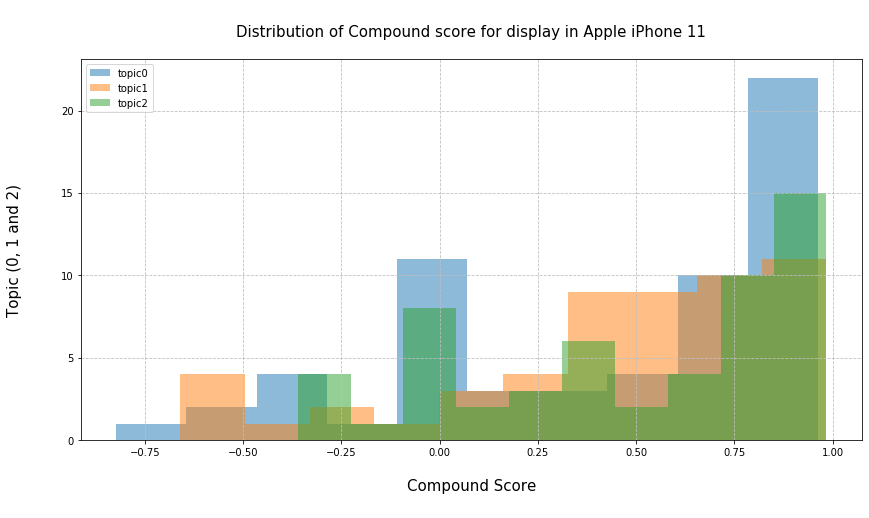

In [58]:
# Section-45
# User Provided Input for Phone and Feature Selection
mobile = 'Apple iPhone 11'
feature = 'display'
output(mobile, feature)